In [1]:
"""
this assumes you already loaded the do_crossvalidation.py script!

"""
import pandas as pd

from sklearn.preprocessing import StandardScaler
import numpy as np
from scripts import dataset
import tensorflow as tf
from scripts.callbacks import all_callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model
import pickle
from sklearn.metrics import roc_curve, auc, precision_recall_curve


## most of this code is borrowed from the hls4ml tutorial :)

class SupervisedClassifier():

    def __init__(self, signal, random_seed=1, train=True):
        self.sig_key = signal
        self.X_train_val, self.X_test, self.y_train_val, self.y_test, self.baseline = dataset.supervised_xtrain_xtest(sig_key=signal)
        self.seed = random_seed
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        self.model = 0
        print(self.sig_key, self.baseline)
        if train:
            self.architecture()
            self.train_model()
        else:
            self.model = load_model(f'trained_models/basic_classifier/model_{self.sig_key}/KERAS_check_best_model.h5')


    def architecture(self):
        model = Sequential()
        model.add(Dense(64, input_shape=(99,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
        model.add(Activation(activation='relu', name='relu1'))
        model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
        model.add(Activation(activation='relu', name='relu2'))
        model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
        model.add(Activation(activation='relu', name='relu3'))
        model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
        model.add(Activation(activation='softmax', name='softmax'))
        self.model = model

    
    def train_model(self):
        adam = Adam(lr=0.0001)
        self.model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
        callbacks = all_callbacks(
            stop_patience=1000,
            lr_factor=0.5,
            lr_patience=10,
            lr_epsilon=0.000001,
            lr_cooldown=2,
            lr_minimum=0.0000001,
            outputDir=f'trained_models/basic_classifier/model_{self.sig_key}',
        )
        self.model.fit(
            self.X_train_val,
            self.y_train_val,
            batch_size=1024,
            epochs=30,
            validation_split=0.25,
            shuffle=True,
            callbacks=callbacks.callbacks,
        )

    def predict_and_save(self):
        results_dict = {}
        y_keras = self.model.predict(self.X_test)
        
        FPR, TPR, _ = roc_curve(y_score=np.max(y_keras, axis=1), y_true=self.y_test[:,0])
        AUC = auc(FPR, TPR)
        precision, recall, _ = precision_recall_curve(probas_pred=np.max(y_keras, axis=1), y_true=self.y_test[:,0])
        PR_AUC = auc(recall, precision)

        results_dict["FPR"] = FPR
        results_dict["TPR"] = TPR
        results_dict["AUC"] = AUC
        results_dict["precision"] = precision
        results_dict["recall"] = recall
        results_dict["PR_AUC"] = PR_AUC


        with open(f'results/supervised_classifier_performance/supervised_{self.sig_key}.pkl', 'wb') as f:
            pickle.dump(results_dict, f)
        print("Data saved successfully.")

In [2]:
sigkeys = ["ttHto2B", "VBFHToInvisible", "GluGluHToGG_M-90", "HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm", "ggXToYYTo2Mu2E_m18", "GluGluHToTauTau", "SMS-Higgsino", "SUSYGluGluToBBHToBB_NarrowWidth_M-120"]
for sig in sigkeys:
    SupervisedClassifier(sig)

ttHto2B 0.20521495748381144
VBFHToInvisible 0.02950097802991143
GluGluHToGG_M-90 0.0917701773398615
HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm 0.0040462895524803755
ggXToYYTo2Mu2E_m18 0.020226780043419868
GluGluHToTauTau 0.28727873325912895
SMS-Higgsino 0.009472268523399779
SUSYGluGluToBBHToBB_NarrowWidth_M-120 0.005052750717490602


In [35]:
import pandas as pd
import pickle

In [32]:
# new_df.sort_values(by=['signal'], ascending=True)
new_df.head(20)

,signal,scoring metric,rocauc,rocauc unc,prauc,prauc unc
17,GluGluHToGG_M-90,adj_density,0.892357,0.003857,0.493788,0.009350
16,GluGluHToGG_M-90,adj_depth,0.922855,0.004130,0.581442,0.011279
20,GluGluHToGG_M-90,boxed_density,0.589577,0.241724,0.189195,0.028071
19,GluGluHToGG_M-90,boxed_density2,0.923606,0.006572,0.589998,0.024108
18,GluGluHToGG_M-90,boxed_ratio,0.944867,0.004341,0.762014,0.025238
15,GluGluHToGG_M-90,density,0.909888,0.002190,0.535107,0.007915
14,GluGluHToGG_M-90,depth,0.923302,0.003253,0.582697,0.013106
58,GluGluHToGG_M-90,supervised_NN,0.605586,0.000000,0.905487,0.000000
38,GluGluHToTauTau,adj_density,0.794536,0.006596,0.633729,0.007878
37,GluGluHToTauTau,adj_depth,0.813706,0.006589,0.664983,0.008716


In [19]:
new_df.head(20)

,signal,scoring metric,rocauc,rocauc unc,prauc,prauc unc
0,ttHto2B,depth,0.992443,0.000676,0.973788,0.002213
2,ttHto2B,adj_depth,0.992358,0.000662,0.973335,0.001778
3,ttHto2B,adj_density,0.986894,0.001326,0.955245,0.003611
4,ttHto2B,boxed_ratio,0.996009,0.000463,0.984694,0.002144
5,ttHto2B,boxed_density2,0.992253,0.000254,0.971832,0.001350
6,ttHto2B,boxed_density,0.654654,0.035390,0.416956,0.150220
56,ttHto2B,supervised_NN,0.937664,0.000000,0.986153,0.000000
1,ttHto2B,density,0.990263,0.000709,0.965256,0.002074
28,ggXToYYTo2Mu2E_m18,depth,0.701525,0.007486,0.055794,0.002026
60,ggXToYYTo2Mu2E_m18,supervised_NN,0.825891,0.000000,0.993589,0.000000


In [3]:
sig_key = "ttHto2B"


results = f'results/supervised_classifier_performance/supervised_{sig_key}.pkl'
with open(results, 'rb') as f:
    results_dict = pickle.load(f)

In [4]:
results_dict.keys()

dict_keys(['FPR', 'TPR', 'AUC', 'precision', 'recall', 'PR_AUC'])

In [5]:
ll = []


In [ ]:
import scripts.cross_validation_script as cvs

In [2]:
kwargs = {"ntrees":10, "scoring_metric": "depth", "ndim":1}


    # def :

In [3]:
cv = cvs.Cross_Validation(kfold=2, model_parameters=kwargs, train_models = True)

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.11/site-packages/isotree/__init__.py:96: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Model trained: trained_models/isotree/kfold_models/model__ntrees_10__scoring_metric_depth__ndim_1__fold_1_of_2.
1
Model trained: trained_models/isotree/kfold_models/model__ntrees_10__scoring_metric_depth__ndim_1__fold_2_of_2.
2


In [6]:
len(cv.x_test_predict[0])

4922800

In [ ]:
cv.getnsave_kfold_auc_prauc(sigkey="ttHto2B")

In [ ]:
from scripts import cross_validation_script


In [3]:
kwargs = {"ntrees":100, "scoring_metric": "depth"}

cv = cross_validation_script.Cross_Validation(kfold=5, model_parameters=kwargs, train_models = True)

This model already exists: trained_models/isotree/kfold_models/model__ntrees_100__scoring_metric_depth__fold_1_of_5.
This model already exists: trained_models/isotree/kfold_models/model__ntrees_100__scoring_metric_depth__fold_2_of_5.
This model already exists: trained_models/isotree/kfold_models/model__ntrees_100__scoring_metric_depth__fold_3_of_5.
This model already exists: trained_models/isotree/kfold_models/model__ntrees_100__scoring_metric_depth__fold_4_of_5.
This model already exists: trained_models/isotree/kfold_models/model__ntrees_100__scoring_metric_depth__fold_5_of_5.


In [4]:
len(cv.x_test_predict[0])

7876480

In [35]:
sigkeys=["ttHto2B", "VBFHToInvisible", "GluGluHToGG_M-90", "HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm", "ggXToYYTo2Mu2E_m18", "GluGluHToTauTau", "SMS-Higgsino", "SUSYGluGluToBBHToBB_NarrowWidth_M-120"]

In [7]:
cv.getnsave_kfold_auc_prauc(sigkey="SUSYGluGluToBBHToBB_NarrowWidth_M-120")

In [6]:
for sig in sigkeys:
    cv.getnsave_kfold_auc_prauc(sigkey=sig)

KeyError: "Unable to open object (object 'SUSYGluGluToBBHToBB_NarrowWidth_M' doesn't exist)"

In [29]:
import matplotlib.pyplot as plt
import numpy as np
def plot_auroc_unc_(mean_curve, error_curve, base, auc_mean, auc_unc): 
    plt.plot(base,mean_curve, linewidth=0.5,  label='BB (AUC = %.1f%% $\pm$ %.1f%%)' % (auc_mean * 100, auc_unc * 100))
    plt.semilogx()
    plt.semilogy()
    plt.fill_between(base,
                mean_curve - error_curve,
                mean_curve + error_curve,
                alpha=0.5,
            label = 'depth')
    plt.legend(loc='lower right',fontsize=15)
    #plt.figure(figsize=(10, 10))
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.xlim([10**-(6), 1.0])
    plt.ylim([10**-(6), 1.05])


In [30]:

def plot_pr_unc_(mean_curve, error_curve, base, auc_mean, auc_unc): 
    plt.plot(base,mean_curve, linewidth=0.5,  label='BB (AUC = %.1f%% $\pm$ %.1f%%)' % (auc_mean * 100, auc_unc * 100))
    # plt.semilogx()
    # plt.semilogy()
    plt.fill_between(base,
                mean_curve - error_curve,
                mean_curve + error_curve,
                alpha=0.5,
            label = 'depth')
    plt.legend(loc='lower right',fontsize=15)
    #plt.figure(figsize=(10, 10))
    # plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    # plt.xlim([10**-(6), 1.0])
    # plt.ylim([10**-(6), 1.05])


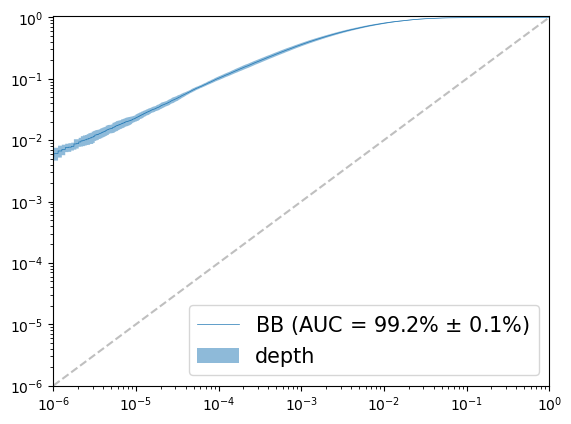

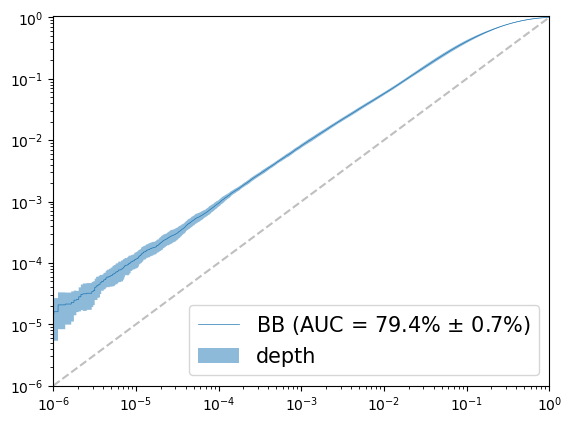

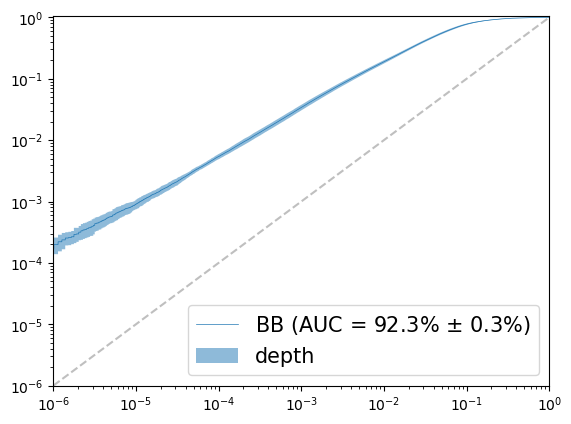

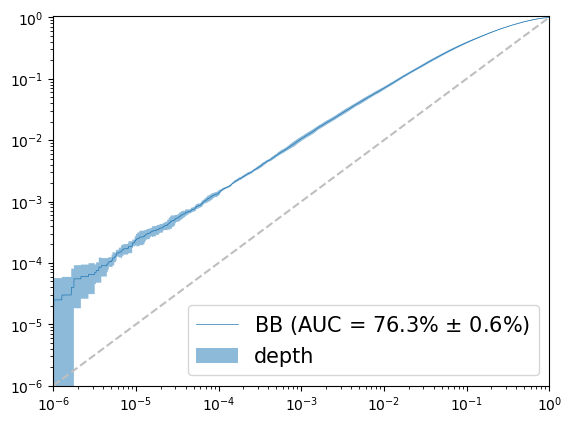

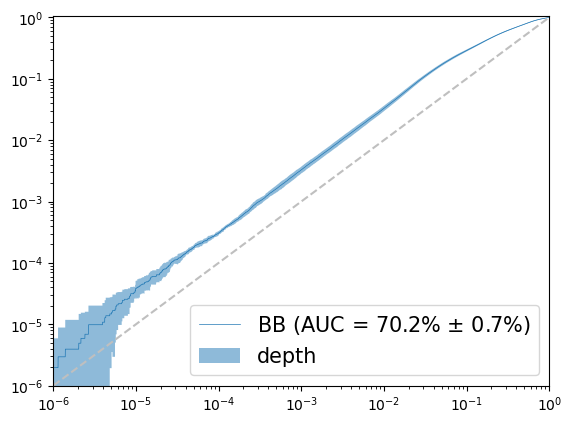

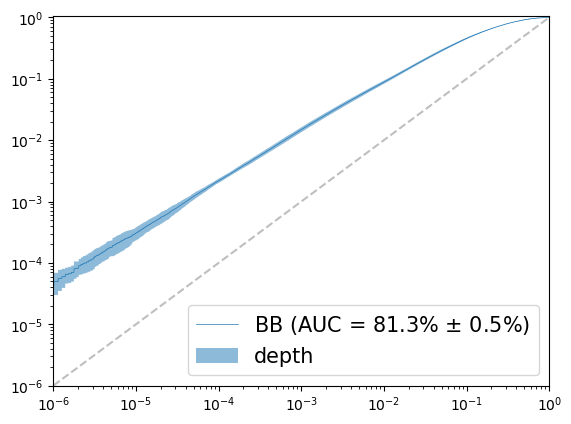

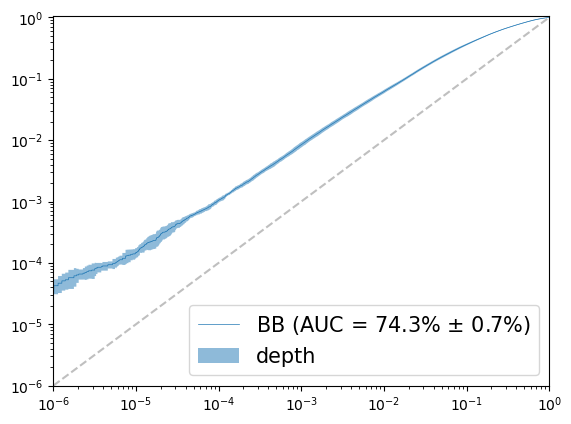

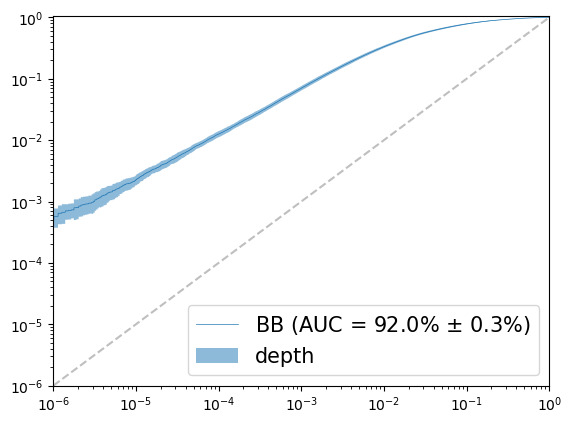

In [37]:
import pickle

# Specify the path to the pickle file
for sig in sigkeys:
    pickle_file_path = f"results/isotree/kfold_models/{sig}_ntrees_100__scoring_metric_depth__5"

    # Load the pickle file
    with open(pickle_file_path, 'rb') as f:
        results_dict = pickle.load(f)

    # Now you can access the data from the dictionary
    ROCAUC_results = results_dict["ROCAUC"]
    PRAUC_results = results_dict["PRAUC"]
    #ROCAUC_results.keys()
    plot_auroc_unc_(ROCAUC_results["mean_curve"], ROCAUC_results["error_curve"], ROCAUC_results["base"], ROCAUC_results["auc_mean"], ROCAUC_results["auc_unc"])
    plt.show()

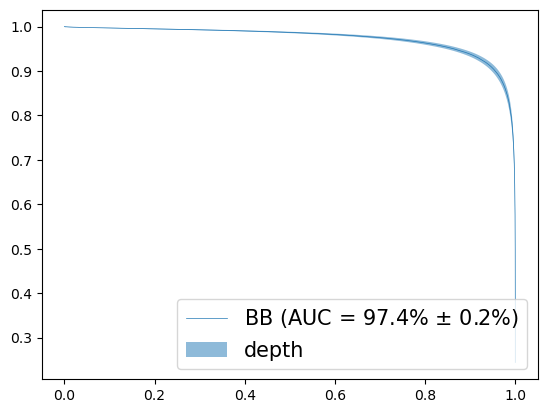

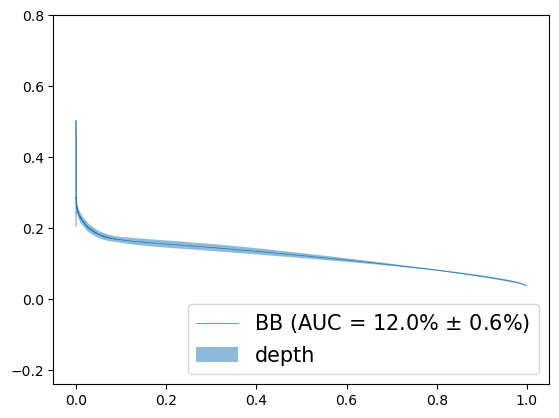

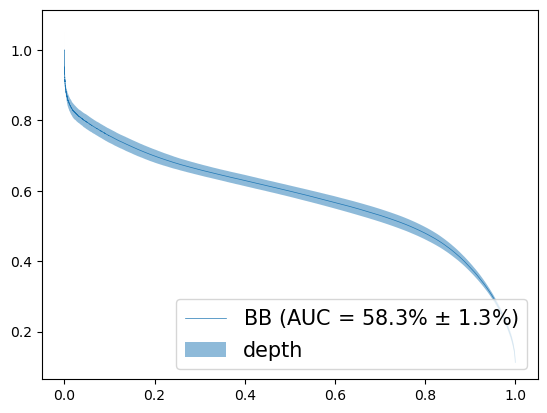

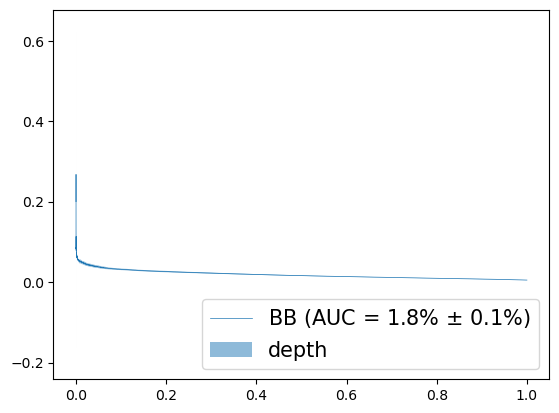

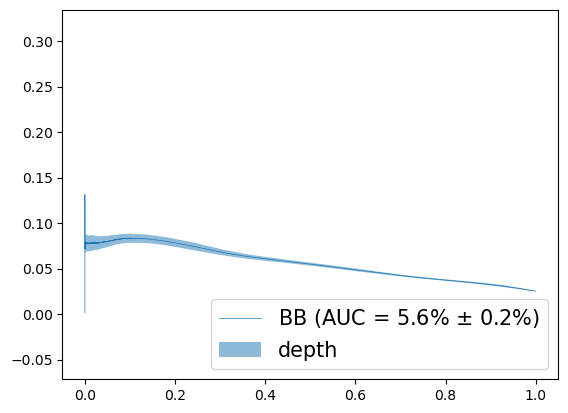

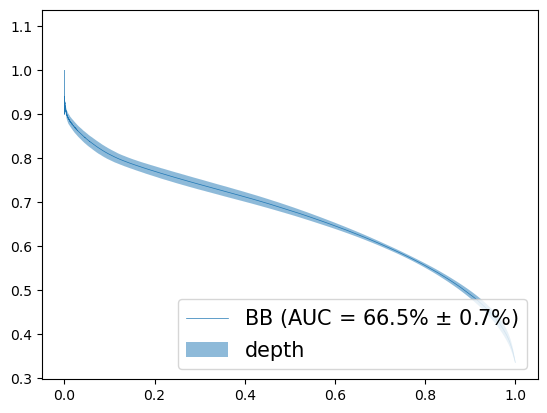

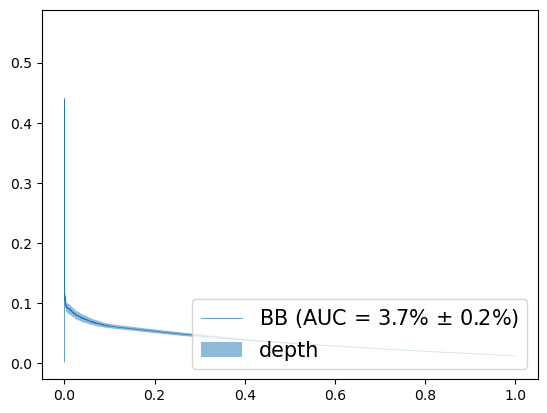

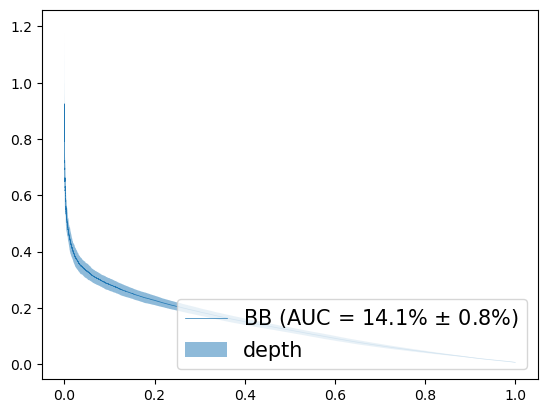

In [38]:
# Specify the path to the pickle file
for sig in sigkeys:
    pickle_file_path = f"results/isotree/kfold_models/{sig}_ntrees_100__scoring_metric_depth__5"

    # Load the pickle file
    with open(pickle_file_path, 'rb') as f:
        results_dict = pickle.load(f)

    # Now you can access the data from the dictionary
    ROCAUC_results = results_dict["ROCAUC"]
    PRAUC_results = results_dict["PRAUC"]
    #ROCAUC_results.keys()
    plot_pr_unc_(PRAUC_results["mean_precision"], PRAUC_results["error_precision"], PRAUC_results["interp_recall"], PRAUC_results["pr_auc_mean"], PRAUC_results["pr_auc_unc"])
    plt.show()

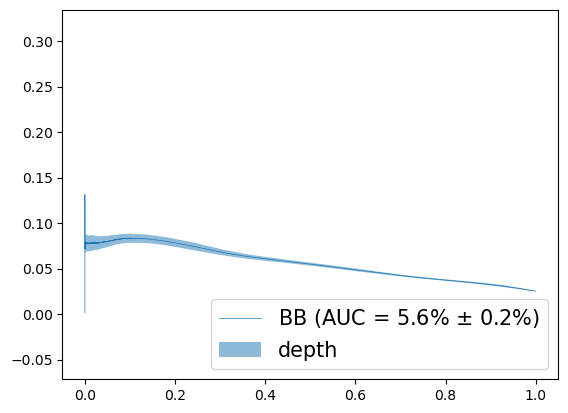

In [32]:
plot_pr_unc_(PRAUC_results["mean_precision"], PRAUC_results["error_precision"], PRAUC_results["interp_recall"], PRAUC_results["pr_auc_mean"], PRAUC_results["pr_auc_unc"])


In [ ]:
pr_auc_mean = results_dict["PRAUC"]['pr_auc_mean']
pr_auc_unc = results_dict["PRAUC"]['pr_auc_unc']
mean_precision = results_dict["PRAUC"]['mean_precision'] 
interp_recall = results_dict["PRAUC"]['interp_recall']

In [2]:
kwargs = {"ntrees":100, "scoring_metric": "depth"}

metric = ["depth", "density", "adj_depth", "adj_density", "boxed_ratio", "boxed_density2", "boxed_density"]

for scoring_metric in metric:
    kwargs["scoring_metric"] = scoring_metric
    cross_validation_script.Cross_Validation(kfold=5, model_parameters=kwargs, sigkey="VBFHToInvisible", train_models = True).getnsave_kfold_auc_prauc()

In [ ]:
kwargs = {"ntrees":100, "scoring_metric": "boxed_ratio"}

# metric = ["depth", "density", "adj_depth", "adj_density", "boxed_ratio", "boxed_density2", "boxed_density"]
metric = ["boxed_ratio", "boxed_density2", "boxed_density"]

for scoring_metric in metric:
    kwargs["scoring_metric"] = scoring_metric
    cross_validation_script.Cross_Validation(kfold=5, model_parameters=kwargs, sigkey="ttHto2B", train_models = True).getnsave_kfold_auc_prauc()

In [ ]:
kwargs = {"ntrees":100, "scoring_metric": "density"}

# metric = ["depth", "density", "adj_depth", "adj_density", "boxed_ratio", "boxed_density2", "boxed_density"]
metric = ["density", "adj_depth", "adj_density"]#, "boxed_ratio", "boxed_density2", "boxed_density"]

for scoring_metric in metric:
    kwargs["scoring_metric"] = scoring_metric
    cross_validation_script.Cross_Validation(kfold=5, model_parameters=kwargs, sigkey="ttHto2B", train_models = True).getnsave_kfold_auc_prauc()

In [ ]:
cross_validation_script.Cross_Validation(kfold=5, model_parameters=kwargs, sigkey="ttHto2B", train_models = True).getnsave_kfold_auc_prauc()


In [ ]:
import pickle

# Specify the path to the pickle file
pickle_file_path = "results/isotree/kfold_models/ttHto2B_ntrees_100__scoring_metric_depth__5"

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    results_dict = pickle.load(f)

# Now you can access the data from the dictionary
ROCAUC_results = results_dict["ROCAUC"]
PRAUC_results = results_dict["PRAUC"]


results_dict["PRAUC"]['pr_auc_mean']
results_dict["PRAUC"]['pr_auc_unc']
results_dict["PRAUC"]['mean_precision'] 
results_dict["PRAUC"]['interp_recall']

# # For example, accessing the AUC mean and uncertainty for ROCAUC
# auc_mean_rocauc = ROCAUC_results["auc_mean"]
# auc_unc_rocauc = ROCAUC_results["auc_unc"]

# # Similarly, for PRAUC
# pr_auc_mean = PRAUC_results["pr_auc_mean"]
# pr_auc_unc = PRAUC_results["pr_auc_unc"]

# # You can access other values similarly


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(PRAUC_results['mean_precision'], PRAUC_results['interp_recall'])

In [ ]:
# AUROC can be little misleading when it comes to performance assesement of imbalanced datasets (like we have here)
# it'd be best to find our region of interest, where we care to know most about the ratio of FPR/TPR !
# like e.g. looking at the trigger rate:

In [ ]:
## for L1 rate estimates from ZeroBias/SingleNuMC
def totalMinBiasRate(nCollBunch = 2500): 
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz

# copied from arturs notebook

In [ ]:
plt.plot(fpr_loss*totalMinBiasRate(), tpr_loss, lw=2, label='BB (AUC = %.1f%%)' % (auc_loss * 100))

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,100)
pass
# what does this mean ? i dont know. probably that my classifier is not so good after all, showcasing the "misleadingness" of auroc here ?
# in general would be cool to re-do arturs plot on showing ""what part of phase space""" we are most sensitive too!! 

In [ ]:
ppp = 0

In [3]:
import pandas as pd

In [14]:
import pickle

pickle_file_path = f"results/isotree/kfold_models/ttHto2B_ntrees_100__scoring_metric_depth__5"

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    results_dict = pickle.load(f)
ROCAUC_results = results_dict["ROCAUC"]
PRAUC_results = results_dict["PRAUC"]

In [ ]:
import pickle

# Specify the path to the pickle file
for sig in sigkeys:
    pickle_file_path = f"results/isotree/kfold_models/{sig}_ntrees_100__scoring_metric_depth__5"

    # Load the pickle file
    with open(pickle_file_path, 'rb') as f:
        results_dict = pickle.load(f)

    # Now you can access the data from the dictionary
    ROCAUC_results = results_dict["ROCAUC"]
    PRAUC_results = results_dict["PRAUC"]
    #ROCAUC_results.keys()
    plot_auroc_unc_(ROCAUC_results["mean_curve"], ROCAUC_results["error_curve"], ROCAUC_results["base"], ROCAUC_results["auc_mean"], ROCAUC_results["auc_unc"])
    plt.show() 

In [ ]:
 #### do a sc

In [28]:
lisss =[]

In [29]:
lisss.append(["sig1","sm1",1,24,35,56])

In [30]:
lisss.append(["sig1","sm2",13,242,5,51])

In [31]:
lisss

[['sig1', 'sm1', 1, 24, 35, 56], ['sig1', 'sm2', 13, 242, 5, 51]]

In [32]:
import pandas as pd

In [33]:
pd.DataFrame(lisss, columns =['signal', 'scoring metric', 'rocauc', 'rocauc unc', 'prauc', 'prauc unc'])

,signal,scoring metric,rocauc,rocauc unc,prauc,prauc unc
0,sig1,sm1,1,24,35,56
1,sig1,sm2,13,242,5,51


In [34]:
sigkeys = ["ttHto2B", "VBFHToInvisible", "GluGluHToGG_M-90", "HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm", "ggXToYYTo2Mu2E_m18", "GluGluHToTauTau", "SMS-Higgsino", "SUSYGluGluToBBHToBB_NarrowWidth_M-120"]
scoring_metrics = ["depth", "density", "adj_depth", "adj_density", "boxed_ratio", "boxed_density2", "boxed_density"]


In [38]:
import pickle
with open('results/isotree/kfold_models/ttHto2B_ntrees_100__scoring_metric_depth__5', 'rb') as f:
    results_dict = pickle.load(f)

In [42]:
results_dict["PRAUC"].keys()

dict_keys(['mean_precision', 'error_precision', 'interp_recall', 'pr_auc_mean', 'pr_auc_unc'])

In [51]:
results_table = []

for sigkey in sigkeys:
    for scoring_metric in scoring_metrics:
        results = f"results/isotree/kfold_models/{sigkey}_ntrees_100__scoring_metric_{scoring_metric}__5"
        with open(results, 'rb') as f:
            results_dict = pickle.load(f)
        # print(results)
        ll = [sigkey, scoring_metric, results_dict["ROCAUC"]["auc_mean"], results_dict["ROCAUC"]["auc_unc"], results_dict["PRAUC"]["pr_auc_mean"], results_dict["PRAUC"]["pr_auc_unc"]]
        results_table.append(ll)

pd.DataFrame(results_table, columns =['signal', 'scoring metric', 'rocauc', 'rocauc unc', 'prauc', 'prauc unc']).to_csv(path_or_buf="results/isotree/kfold_models/results_kfold.csv")

In [52]:
pd.DataFrame(results_table, columns =['signal', 'scoring metric', 'rocauc', 'rocauc unc', 'prauc', 'prauc unc']).to_csv(path_or_buf="results/isotree/kfold_models/results_kfold.csv")

In [37]:
import pickle
with open('results/isotree/kfold_models/ttHto2B_ntrees_100__scoring_metric_depth__5', 'rb') as f:
    results_dict = pickle.load(f)

In [38]:
results_dict["PRAUC"].keys()

dict_keys(['mean_precision', 'error_precision', 'interp_recall', 'pr_auc_mean', 'pr_auc_unc'])

In [39]:
results_dict["PRAUC"].keys()

precision = results_dict["PRAUC"]["mean_precision"]
recall = results_dict["PRAUC"]["interp_recall"]
pr_auc = results_dict["PRAUC"]["pr_auc_mean"]
error_curve = results_dict["PRAUC"]["error_precision"]

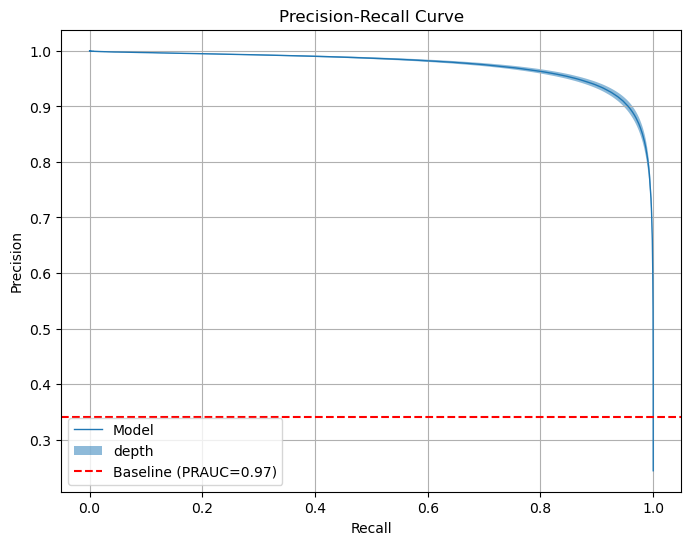

In [42]:
import matplotlib.pyplot as plt

# Assuming you have calculated precision and recall values
# List of precision values
   # List of recall values

# Baseline precision
baseline_precision = 0.341  # 1% baseline precision

# Calculate PR AUC
# Assuming you have already calculated PR AUC and stored it in a variable named pr_auc
# pr_auc = 0.07  # Example PR AUC value

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=1, linestyle='-', label='Model')# marker='o', 
plt.fill_between(recall,
                precision - error_curve,
                precision + error_curve,
                alpha=0.5,
            label = 'depth')
plt.axhline(y=baseline_precision, color='r', linestyle='--', label=f'Baseline (PRAUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()
